In [13]:
import numpy as np
from random import random, randint, seed
from statistics import mean
from copy import deepcopy
import math


### 0. Hyperparameters

In [14]:
POP_SIZE        = 60   # population size
MIN_DEPTH       = 2    # minimal initial random tree depth
MAX_DEPTH       = 5    # maximal initial random tree depth
GENERATIONS     = 250  # maximal number of generations to run evolution
TOURNAMENT_SIZE = 5    # size of tournament for tournament selection
XO_RATE         = 0.8  # crossover rate 
PROB_MUTATION   = 0.2  # per-node mutation probability 

### 1. Terminals & Non-Terminals

In [15]:
def add(a, b):
    return a + b

def sub(a, b):
    return a - b

def mul(a, b):
    return a * b

def div(a, b):
    if b != 0:
        return a / b
    return 1 #to avoid division by 1

def fact(n,_):
    return math.factorial(abs(n))

In [16]:
FUNCTIONS = [add, sub, mul, div, fact]
TERMINALS = ['x', -2, -1, 0, 1, 2]

### 2. Creating target function and sequence

In [17]:
def target_func(n):
    return math.factorial(2 * n) // (math.factorial(n + 1) * math.factorial(n))

def generate_dataset(length):
    ans = []
    for i in range(1,length):
        ans.append((i,target_func(i)))
    return ans

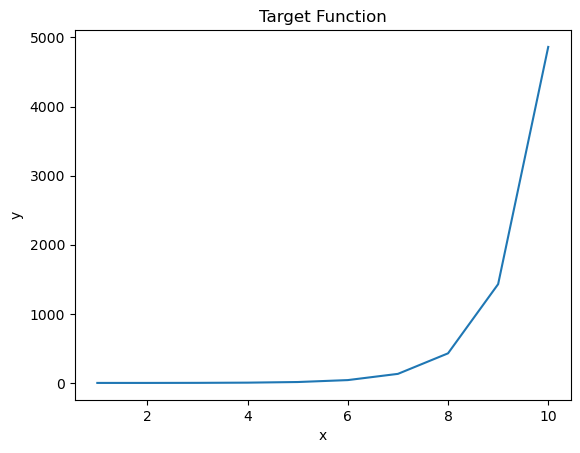

In [18]:
import matplotlib.pyplot as plt

# create sequence of x values
x_seq = np.arange(1, 11)

# apply target function to each x value to get corresponding y value
y_seq = [target_func(x) for x in range(len(x_seq))]

# plot x-y pairs
plt.plot(x_seq, y_seq)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Target Function')
plt.show()


### 3. Genetic Programming Tree

In [25]:
class GPTree:
    def __init__(self, data = None, left = None, right = None):
        self.data  = data
        self.left  = left
        self.right = right
        
    def node_label(self): # string label
        if (self.data in FUNCTIONS):
            return self.data.__name__
        else: 
            return str(self.data)
    
    def print_tree(self, prefix = ""): # textual printout
        print("%s%s" % (prefix, self.node_label()))        
        if self.left:  self.left.print_tree (prefix + "   ")
        if self.right: self.right.print_tree(prefix + "   ")

    def compute_tree(self, x): 
        if (self.data in FUNCTIONS): 
            return self.data(self.left.compute_tree(x), self.right.compute_tree(x))
        elif self.data == 'x': return x
        else: return self.data
            
    def random_tree(self, grow, max_depth, depth = 0): # create random tree using either grow or full method
        if depth < MIN_DEPTH or (depth < max_depth and not grow): 
            self.data = FUNCTIONS[randint(0, len(FUNCTIONS)-1)]
        elif depth >= max_depth:   
            self.data = TERMINALS[randint(0, len(TERMINALS)-1)]
        else: # intermediate depth, grow
            if random () > 0.5: 
                self.data = TERMINALS[randint(0, len(TERMINALS)-1)]
            else:
                self.data = FUNCTIONS[randint(0, len(FUNCTIONS)-1)]
        if self.data in FUNCTIONS:
            self.left = GPTree()          
            self.left.random_tree(grow, max_depth, depth = depth + 1)            
            self.right = GPTree()
            self.right.random_tree(grow, max_depth, depth = depth + 1)

    def mutation(self):
        if random() < PROB_MUTATION: # mutate at this node
            self.random_tree(grow = True, max_depth = 2)
        elif self.left: self.left.mutation()
        elif self.right: self.right.mutation() 

    def size(self): # tree size in nodes
        if self.data in TERMINALS: return 1
        l = self.left.size()  if self.left  else 0
        r = self.right.size() if self.right else 0
        return 1 + l + r

    def build_subtree(self):
        t = GPTree()
        t.data = self.data
        if self.left:  t.left  = self.left.build_subtree()
        if self.right: t.right = self.right.build_subtree()
        return t
                        
    def scan_tree(self, count, second):
        count[0] -= 1            
        if count[0] <= 1: 
            if not second: # return subtree rooted here
                return self.build_subtree()
            else: # glue subtree here
                self.data  = second.data
                self.left  = second.left
                self.right = second.right
        else:  
            ret = None              
            if self.left  and count[0] > 1: ret = self.left.scan_tree(count, second)  
            if self.right and count[0] > 1: ret = self.right.scan_tree(count, second)  
            return ret

    def crossover(self, other): # xo 2 trees at random nodes
        if random() < XO_RATE:
            second = other.scan_tree([randint(1, other.size())], None) # 2nd random subtree
            self.scan_tree([randint(1, self.size())], second) # 2nd subtree "glued" inside 1st tree

### 4. Fitness and selection

In [26]:
def fitness(individual, dataset):
    return (1 + mean([abs(individual.compute_tree(ds[0]) - ds[1]) for ds in dataset]))

In [27]:
def selection(population, fitnesses): # select one individual using tournament selection
    tournament = [randint(0, len(population)-1) for i in range(TOURNAMENT_SIZE)] # select tournament contenders
    tournament_fitnesses = [fitnesses[tournament[i]] for i in range(TOURNAMENT_SIZE)]
    return deepcopy(population[tournament[tournament_fitnesses.index(max(tournament_fitnesses))]]) 

In [28]:
def roulette_selection(population, fitnesses):
    # calculate total fitness of population
    total_fitness = sum(fitnesses)
    
    # calculate probability of selection for each individual
    probabilities = [fitness / total_fitness for fitness in fitnesses]
    
    # create a cumulative probability distribution
    cumulative_probabilities = [sum(probabilities[:i+1]) for i in range(len(probabilities))]
    
    # select individuals using roulette wheel selection
    selected = []
    for i in range(len(population)):
        r = random()
        for j in range(len(cumulative_probabilities)):
            if r <= cumulative_probabilities[j]:
                selected.append(deepcopy(population[j]))
                break
                
    return selected

In [29]:
def init_population(): # ramped half-and-half
    pop = []
    for md in range(3, MAX_DEPTH + 1):
        for i in range(int(POP_SIZE/6)):
            t = GPTree()
            t.random_tree(grow = True, max_depth = md) # grow
            pop.append(t) 
        for i in range(int(POP_SIZE/6)):
            t = GPTree()
            t.random_tree(grow = False, max_depth = md) # full
            pop.append(t) 
    return pop

### 5.Main Loop

In [ ]:
dataset = generate_dataset(200)
population = init_population() 
best_of_run = None
best_of_run_f = 0
best_of_run_gen = 0
fitnesses = [fitness(population[i], dataset) for i in range(POP_SIZE)]

# go evolution!
for gen in range(GENERATIONS):    
    print(f"Generation: {gen}")    
    nextgen_population=[]
    for i in range(POP_SIZE):
        parent1 = selection(population, fitnesses)
        parent2 = selection(population, fitnesses)
        parent1.crossover(parent2)
        parent1.mutation()
        nextgen_population.append(parent1)
    population=nextgen_population
    fitnesses = [fitness(population[i], dataset) for i in range(POP_SIZE)]
    if max(fitnesses) > best_of_run_f:
        best_of_run_f = max(fitnesses)
        best_of_run_gen = gen
        best_of_run = deepcopy(population[fitnesses.index(max(fitnesses))])
        print("________________________")
        print("gen:", gen, ", best_of_run_f:", round(max(fitnesses),3), ", best_of_run:") 
        best_of_run.print_tree()
    if best_of_run_f == 1: break   

print("\n\n_________________________________________________\nEND OF RUN\nbest_of_run attained at gen " + str(best_of_run_gen) +\
        " and has f=" + str(round(best_of_run_f,3)))
best_of_run.print_tree()